In [7]:
!pip install pandas numpy scikit-learn matplotlib statsmodels pmdarima tensorflow yfinance

In [8]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from math import sqrt

In [26]:
df = data['TSLA'][['Adj Close']].copy()

In [27]:
# Load and preprocess Tesla data
df = data['TSLA'][['Adj Close']].copy()
df.dropna(inplace=True)

df.fillna(method='ffill', inplace=True)

# Split data into training and testing sets (e.g., last 20% for testing)
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]

<ipython-input-27-2eb3a02789a0>:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


In [37]:
def evaluate_forecast_lstm(y_true, y_pred):
    # Calculate MAE
    mae = mean_absolute_error(y_true, y_pred)

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    # Calculate MAPE, handle division by zero by adding a small constant
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-10))) * 100  # Small constant to avoid zero division

    print(f"Evaluation Metrics for LSTM Model:\nMAE: {mae}\nRMSE: {rmse}\nMAPE: {mape}%")
    return mae, rmse, mape


In [34]:
# Normalize data for LSTM
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

# Prepare data for LSTM (sequence length of 60 days)
def create_sequences(data, seq_length=60):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_scaled)
X_test, y_test = create_sequences(test_scaled)


In [35]:
lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(50),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mse')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lstm_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1, callbacks=[early_stopping])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.0232 - val_loss: 0.0066
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 8.0866e-04 - val_loss: 0.0052
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 7.2821e-04 - val_loss: 0.0043
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.3108e-04 - val_loss: 0.0069
Epoch 5/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.7721e-04 - val_loss: 0.0034
Epoch 6/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.2554e-04 - val_loss: 0.0029
Epoch 7/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 6.8536e-04 - val_loss: 0.0026
Epoch 8/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.6600e-04 - val_loss: 0.0024
Epoch 9/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 4.9422e-04 - val_loss: 0.0032
Epoch 10/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 4.4117e-04 - val_loss: 0.0020
Epoch 11/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 3.7986e-04 - val_loss: 0.0020
Epoch 12/20
54/54 ━━━━━━━━━━━

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
MAE: 8.107596421515805, RMSE: 10.758376849989222, MAPE: 3.7993097751346525%


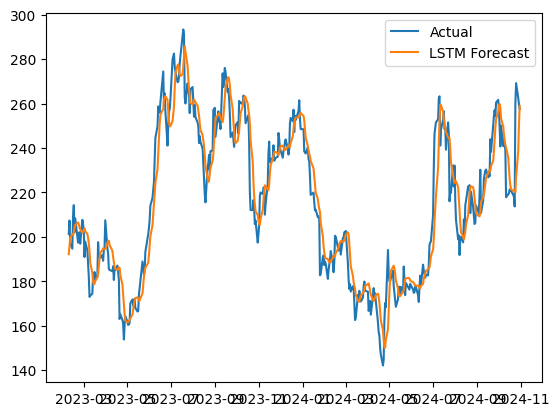

In [36]:
# Forecast using LSTM
lstm_predictions = lstm_model.predict(X_test)
lstm_predictions = scaler.inverse_transform(lstm_predictions)  # Inverse scaling

# Evaluate LSTM
evaluate_forecast(test[-len(lstm_predictions):], lstm_predictions)

# Plotting results
plt.plot(test.index[-len(lstm_predictions):], test[-len(lstm_predictions):], label="Actual")
plt.plot(test.index[-len(lstm_predictions):], lstm_predictions, label="LSTM Forecast")
plt.legend()
plt.show()

In [38]:
# Make predictions with LSTM model on the test set
lstm_predictions_scaled = lstm_model.predict(X_test)

# Inverse transform predictions to get them back to original scale
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

# Inverse transform the true test values
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [39]:
# Calculate evaluation metrics
mae, rmse, mape = evaluate_forecast_lstm(y_test_original, lstm_predictions)

Evaluation Metrics for LSTM Model:
MAE: 8.107596421515805
RMSE: 10.758376849989222
MAPE: 3.7993097751328198%
